In [ ]:
!pip -q install pyyaml

Please upload the ZIP that contains your call files (JSON or YAML).


Saving All_Conversations.zip to All_Conversations (1).zip
Extracted to /content/data
Found 253 calls. Example IDs: ['00be25b0-458f-4cbf-ae86-ae2ec1f7fba4', '019b9e97-9575-459e-9893-b59d8c99acef', '019b9e97-9575-459e-9893-b59d8c99acef-checkpoint', '02b08433-58e0-46af-961e-221ba94cb8df', '02f1cff9-7d47-4168-b1f9-d9fba10847a0', '03132d8f-6a7d-47d0-9540-c6a0ac32d946', '04bec80f-8614-484b-8ba2-831ff9dd03ef', '05731aab-0e72-46c1-8fd3-dc50fb20c758', '084fc190-bccc-472f-a6f8-de13e814c67d', '0b6979e4-8c05-49e1-b7a7-94d85a627df5']
Enter call_id to visualize (use the filename without extension): 019b9e97-9575-459e-9893-b59d8c99acef


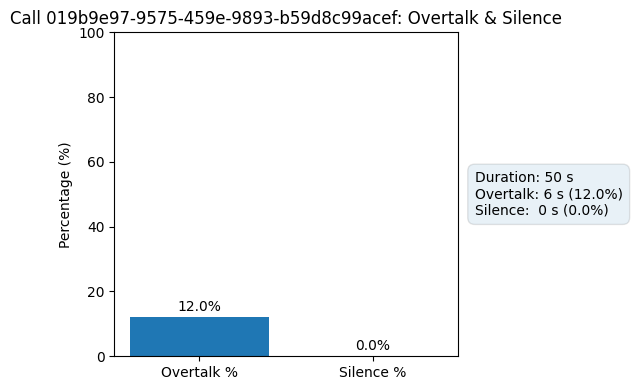

In [2]:

import os
import io
import json
import yaml
import zipfile
import unicodedata
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from google.colab import files

# 1) Upload and extract ZIP

print("Please upload the ZIP that contains your call files (JSON or YAML).")
up = files.upload()  # choose e.g., All_Conversations.zip
if not up:
    raise RuntimeError("No file uploaded.")
zip_name = next(iter(up.keys()))
zip_bytes = up[zip_name]

DATA_DIR = "/content/data"
os.makedirs(DATA_DIR, exist_ok=True)

with zipfile.ZipFile(io.BytesIO(zip_bytes), 'r') as zf:
    zf.extractall(DATA_DIR)
print(f"Extracted to {DATA_DIR}")


# 2) Helpers

def nfkc(s: str) -> str:
    t = unicodedata.normalize("NFKC", s or "")
    return " ".join(t.split())

def norm_speaker(s: str) -> str:
    s = (s or "").strip().lower()
    if s == "agent": return "agent"
    if s in ("customer", "borrower"): return "customer"
    return "unknown"

Interval = Tuple[int, int]  # [start, end)

def merge_intervals(iv: List[Interval]) -> List[Interval]:
    if not iv: return []
    iv = sorted(iv, key=lambda x: (x[0], x[1]))
    out = [iv[0]]
    for s, e in iv[1:]:
        ps, pe = out[-1]
        if s <= pe:             # merge overlap or touching for any-speech
            out[-1] = (ps, max(pe, e))
        else:
            out.append((s, e))
    return out

def union_length(iv: List[Interval]) -> int:
    merged = merge_intervals(iv)
    return sum(e - s for s, e in merged)

def intersect_two_sets(a: List[Interval], b: List[Interval]) -> List[Interval]:
    a = merge_intervals(a)
    b = merge_intervals(b)
    i = j = 0
    out = []
    while i < len(a) and j < len(b):
        s1, e1 = a[i]; s2, e2 = b[j]
        s = max(s1, s2); e = min(e1, e2)
        if s < e:
            out.append((s, e))
        if e1 <= e2: i += 1
        else: j += 1
    return out


# 3) IO

def load_call(path: str) -> Dict:
    call_id = os.path.splitext(os.path.basename(path))[0]
    ext = os.path.splitext(path)[1].lower()
    with open(path, "r", encoding="utf-8") as f:
        if ext in (".yaml", ".yml"):
            data = yaml.safe_load(f)
        elif ext == ".json":
            data = json.load(f)
        else:
            raise ValueError(f"Unsupported file type: {ext}")

    turns_raw = data["turns"] if isinstance(data, dict) and "turns" in data else data
    turns = []
    for i, t in enumerate(turns_raw or []):
        sp = norm_speaker(t.get("speaker", ""))
        st = t.get("stime", 0)
        et = t.get("etime", 0)
        try: st = int(st)
        except: st = 0
        try: et = int(et)
        except: et = st
        if et < st: et = st
        txt = t.get("text", "")
        turns.append({
            "idx": i,
            "speaker": sp,
            "stime": st,
            "etime": et,
            "text_raw": txt,
            "text_norm": nfkc(txt),
        })
    return {"call_id": call_id, "turns": turns}

def load_all_calls(root_dir: str) -> Dict[str, Dict]:
    calls = {}
    for dirpath, _, filenames in os.walk(root_dir):
        for fn in filenames:
            if fn.lower().endswith((".yaml", ".yml", ".json")):
                path = os.path.join(dirpath, fn)
                try:
                    c = load_call(path)
                    calls[c["call_id"]] = c
                except Exception as e:
                    print(f"Skip {fn}: {e}")
    return calls


# 4) Metrics

def intervals_from_turns(turns: List[Dict], who: str) -> List[Interval]:
    return [(t["stime"], t["etime"]) for t in turns if t["speaker"] == who and t["etime"] > t["stime"]]

def compute_metrics(call: Dict) -> Dict:
    cid = call["call_id"]
    ts = call["turns"]
    if not ts:
        return {"call_id": cid, "duration_sec": 0, "overtalk_sec": 0, "overtalk_pct": 0.0, "silence_sec": 0, "silence_pct": 0.0}
    start = min(t["stime"] for t in ts)
    end = max(t["etime"] for t in ts)
    dur = max(0, end - start)

    a_iv = intervals_from_turns(ts, "agent")
    c_iv = intervals_from_turns(ts, "customer")

    any_len = union_length(a_iv + c_iv)
    over_iv = intersect_two_sets(a_iv, c_iv)
    over_len = sum(e - s for s, e in over_iv)
    silence_len = max(0, dur - any_len)

    over_pct = (over_len / dur) if dur > 0 else 0.0
    silence_pct = (silence_len / dur) if dur > 0 else 0.0

    return {
        "call_id": cid,
        "duration_sec": dur,
        "overtalk_sec": over_len,
        "overtalk_pct": over_pct,
        "silence_sec": silence_len,
        "silence_pct": silence_pct,
    }

# 5) Plotting (single call)

def plot_call_bars(call_id: str, metrics_map: Dict[str, Dict]):
    if call_id not in metrics_map:
        raise ValueError(f"call_id '{call_id}' not found.")
    m = metrics_map[call_id]
    labels = ["Overtalk %", "Silence %"]
    vals = [m["overtalk_pct"] * 100.0, m["silence_pct"] * 100.0]

    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(labels, vals)
    ax.set_ylim(0, 100)
    ax.set_ylabel("Percentage (%)")
    ax.set_title(f"Call {call_id}: Overtalk & Silence")
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, h + 1, f"{h:.1f}%", ha="center", va="bottom", fontsize=10)

    info = (
        f"Duration: {m['duration_sec']} s\n"
        f"Overtalk: {m['overtalk_sec']} s ({m['overtalk_pct']*100:.1f}%)\n"
        f"Silence:  {m['silence_sec']} s ({m['silence_pct']*100:.1f}%)"
    )
    ax.text(1.05, 0.5, info, transform=ax.transAxes, va="center",
            bbox=dict(boxstyle="round", alpha=0.1, pad=0.5), fontsize=10)
    plt.tight_layout()
    plt.show()


# 6) Run

calls = load_all_calls(DATA_DIR)
metrics_map = {cid: compute_metrics(c) for cid, c in calls.items()}
print(f"Found {len(metrics_map)} calls. Example IDs:", list(sorted(metrics_map.keys()))[:10])

# Ask for a call_id and show only that call's chart
try:
    user_id = input("Enter call_id to visualize (use the filename without extension): ").strip()
    if user_id:
        plot_call_bars(user_id, metrics_map)
    else:
        print("No call_id entered. Per-call plot skipped.")
except EOFError:
    print("Input not available; per-call plot skipped.")


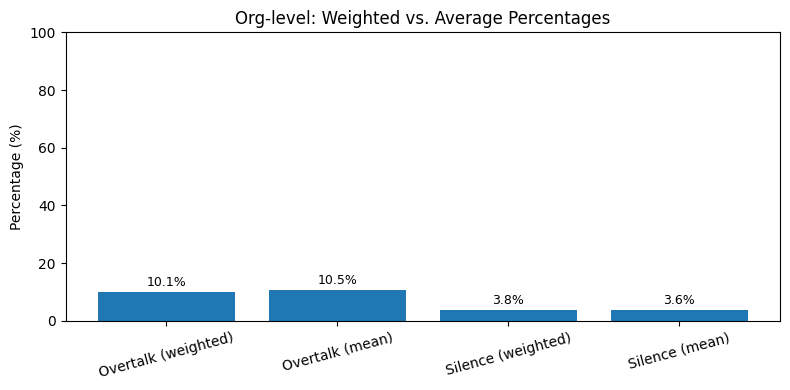

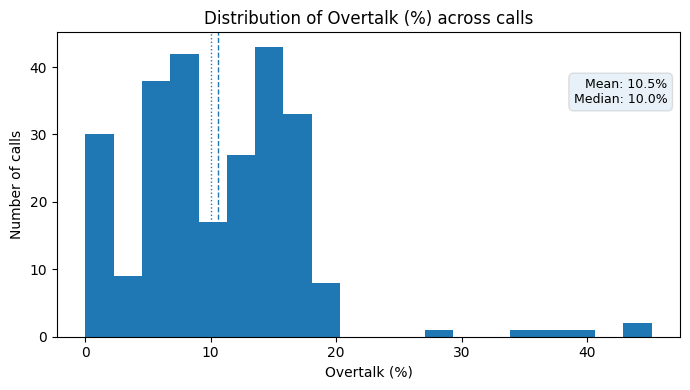

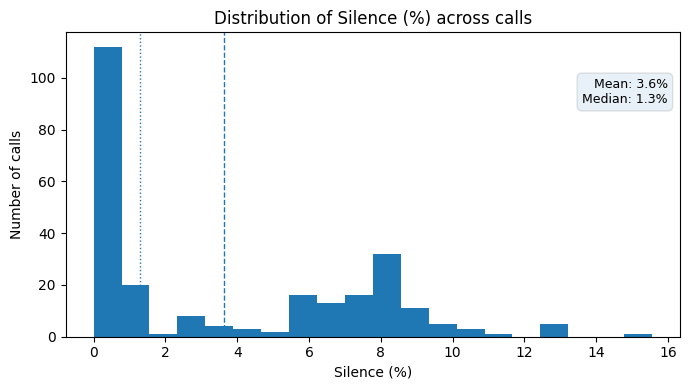

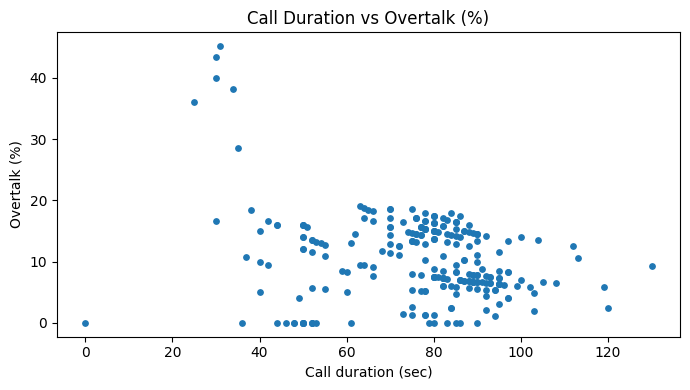

Saved per-call metrics to: /content/q3_per_call_metrics.csv


In [4]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0) Build per-call DataFrame (rebuild if needed)
if "metrics_map" not in globals():
    try:
        calls = load_all_calls(DATA_DIR)
        metrics_map = {cid: compute_metrics(c) for cid, c in calls.items()}
        print(f"[Rebuilt] Found {len(metrics_map)} calls from {DATA_DIR}")
    except Exception as e:
        raise RuntimeError("metrics_map not found and rebuild failed. Run the earlier cell first.") from e

rows = []
for cid, m in metrics_map.items():
    rows.append({
        "call_id": cid,
        "duration_sec": m["duration_sec"],
        "overtalk_sec": m["overtalk_sec"],
        "silence_sec": m["silence_sec"],
        "overtalk_pct": m["overtalk_pct"] * 100.0,  # %
        "silence_pct": m["silence_pct"] * 100.0,    # %
    })
df = pd.DataFrame(rows).sort_values("call_id").reset_index(drop=True)
if df.empty:
    raise RuntimeError("No calls found to visualize.")

# 1) Compute org-level stats
total_duration = df["duration_sec"].sum()
weighted_overtalk_pct = (df["overtalk_sec"].sum() / total_duration * 100.0) if total_duration > 0 else 0.0
weighted_silence_pct  = (df["silence_sec"].sum()  / total_duration * 100.0) if total_duration > 0 else 0.0
mean_overtalk_pct = df["overtalk_pct"].mean()
mean_silence_pct  = df["silence_pct"].mean()
med_overtalk = df["overtalk_pct"].median()
med_silence  = df["silence_pct"].median()

# 2) Bar chart: weighted vs mean (unweighted) for both metrics
labels = ["Overtalk (weighted)", "Overtalk (mean)", "Silence (weighted)", "Silence (mean)"]
vals = [weighted_overtalk_pct, mean_overtalk_pct, weighted_silence_pct, mean_silence_pct]

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(labels, vals)
ax.set_ylim(0, 100)
ax.set_ylabel("Percentage (%)")
ax.set_title("Org-level: Weighted vs. Average Percentages")
for b in bars:
    h = b.get_height()
    ax.text(b.get_x() + b.get_width()/2, h + 1, f"{h:.1f}%", ha="center", va="bottom", fontsize=9)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# 3) Histogram: overtalk%
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(df["overtalk_pct"].values, bins=20)
ax.axvline(mean_overtalk_pct, linestyle="--", linewidth=1)
ax.axvline(med_overtalk, linestyle=":", linewidth=1)
ax.set_xlabel("Overtalk (%)")
ax.set_ylabel("Number of calls")
ax.set_title("Distribution of Overtalk (%) across calls")
ax.text(0.98, 0.85,
        f"Mean: {mean_overtalk_pct:.1f}%\nMedian: {med_overtalk:.1f}%",
        transform=ax.transAxes, ha="right", va="top", fontsize=9,
        bbox=dict(boxstyle="round", alpha=0.1, pad=0.4))
plt.tight_layout()
plt.show()

# 4) Histogram: silence%
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(df["silence_pct"].values, bins=20)
ax.axvline(mean_silence_pct, linestyle="--", linewidth=1)
ax.axvline(med_silence, linestyle=":", linewidth=1)
ax.set_xlabel("Silence (%)")
ax.set_ylabel("Number of calls")
ax.set_title("Distribution of Silence (%) across calls")
ax.text(0.98, 0.85,
        f"Mean: {mean_silence_pct:.1f}%\nMedian: {med_silence:.1f}%",
        transform=ax.transAxes, ha="right", va="top", fontsize=9,
        bbox=dict(boxstyle="round", alpha=0.1, pad=0.4))
plt.tight_layout()
plt.show()

# 5) Scatter: call duration vs overtalk%
fig, ax = plt.subplots(figsize=(7, 4))
ax.scatter(df["duration_sec"].values, df["overtalk_pct"].values, s=15)
ax.set_xlabel("Call duration (sec)")
ax.set_ylabel("Overtalk (%)")
ax.set_title("Call Duration vs Overtalk (%)")
plt.tight_layout()
plt.show()

# Optional: save a CSV if you haven’t already
out_csv = "/content/q3_per_call_metrics.csv"
df.to_csv(out_csv, index=False)
print(f"Saved per-call metrics to: {out_csv}")
